In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn

In [2]:
GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']
err_grb = GRBs
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
for grb in err_grb:
    
    
    grbname = grb + '.txt'
    grbname_wtht_ext = grbname.replace('.txt','')


    arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
    data = [arr[:,0], arr[:,1], arr[:,2]]
    x = arr[:,0]
    y = arr[:,1]
    yerr = arr[:,2]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    H0=67.36 #Hubble constant km -1 Mpc s -1
    omega_m = 0.315
    omega_l = 1 - omega_m
    grb
    #MODELS

    #NULL model
    def nullhp(E, alpha, tau):
        return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
        


    def int_z(z_prime, n):
        integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
        return quad( integ_fn, a=0, b=z_prime)[0]

    int_z1 = np.asarray(int_z(z_com, 1))
    int_z2 = np.asarray(int_z(z_com, 2))

    #LINEAR model
    def linearhp(E, logEqg, alpha, tau):
        
        e0qg = (E + E0) / (10 ** logEqg)
        
        return - (e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

    #QUADRATIC model
    def quadhp(E, logEqg, alpha, tau):
        e0qg = (E**2 + E0 **2) / ((10 ** logEqg)**2)
        
        return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, alpha, tau)
    #LOG-LIKELIHOODS
    def loglike_null(theta):
        alpha, tau = theta
        
        
        model = nullhp(x,  alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
        
        

    def loglike_linear(theta):
        logEqg, alpha, tau = theta
        
        model = linearhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

    def loglike_quad(theta):
        logEqg, alpha, tau = theta
        
        model = quadhp(x, logEqg, alpha, tau)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


    alphamin = -1
    alphamax = 1
    taumin = -10
    taumax = 10
    logeqmin = 6
    logeqmax = 19
    #PRIOR DISTRIBUTIONS

    def prior_transform_null(theta):
        alpha, tau = theta
        return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_linear(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    def prior_transform_quadratic(theta):
        logEqg, alpha, tau = theta
        return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

    #Properties of GRB
    E0 = grbparam[grbname.replace('.txt','')].E0
    E0rest = E0
    Erest = arr[:,0]    #in keV
    z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
    threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
    sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
    sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
    sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
    results0 = sampler0.results
    results1 = sampler1.results
    results2 = sampler2.results
    with open('outputs/BF/' + grb + '_results.txt', 'w') as f:
        f.write(str(results0.logz[-1]) + ',' + str(results0.logzerr[-1]) + '\n')
        f.write(str(results1.logz[-1]) + ',' + str(results1.logzerr[-1]) + '\n')
        f.write(str(results2.logz[-1]) + ',' + str(results2.logzerr[-1]) + '\n')

In [3]:
data = []
for grb in GRBs:
    temp = np.loadtxt('./outputs/BF/' + grb + '_results.txt', delimiter=',')[:,0]
    # data.append( [grb, grbparam[grb].E0, grbparam[grb].redshift, *np.exp(temp - temp[0])]  )
    data.append( [grb, grbparam[grb].E0, grbparam[grb].redshift, *(temp - temp[0])]  )
    # data.append( [grb, grbparam[grb].E0, grbparam[grb].redshift, *temp]  )

In [4]:
df = pd.DataFrame(data, columns=['GRB', 'E0 (keV)', 'redshift', 'null', 'linear', 'quadratic']).sort_values('GRB', ascending=False).reset_index(drop=True)

# df.to_latex('./outputs/BE/BE_table.txt', index=False, float_format="%.2f")
# df

In [5]:
df

,GRB,E0 (keV),redshift,null,linear,quadratic
0,GRB210619B,10.0,1.9370,0.0,22.823529,15.406687
1,GRB210610B,30.0,1.1300,0.0,1.067316,88.839915
2,GRB210204A,10.0,0.8760,0.0,31.178076,31.718897
3,GRB201216C,15.0,1.1000,0.0,-0.609720,-0.198209
4,GRB200829A,25.0,1.2500,0.0,184.586108,180.376537
5,GRB200613A,30.0,1.2200,0.0,-1.089988,-0.092508
6,GRB190114C,10.0,0.4250,0.0,148.731452,101.319164
7,GRB180720B,25.0,0.6540,0.0,3.810441,1.842176
8,GRB180703A,20.0,0.6678,0.0,41.777865,11.457315
9,GRB171010A,10.0,0.3285,0.0,20.788819,18.456242


In [6]:
data = []
for i in os.listdir('./outputs/GOF/'):
    # with open('./outputs/GOF/' + i, 'rb') as f:
    #     data.append(np.load(f))
    if i.endswith('_GOF.txt'):
        data.append([i.replace('_GOF.txt', ''), *np.loadtxt('./outputs/GOF/' + i)])
df2 = pd.DataFrame(data, columns=['GRB2', 'Null', 'Linear', 'Quadratic'])
# df2.index = df2['GRB']

df2.sort_values('GRB2', inplace=True, ascending=False)
df2.reset_index(drop=True, inplace=True)
# df2.drop('GRB', axis=1, inplace=True)

In [7]:
df2

,GRB2,Null,Linear,Quadratic
0,GRB210619B,8.731972,6.174641,6.409208
1,GRB210610B,13.700761,13.553688,3.479048
2,GRB210204A,12.137520,8.688145,8.600105
3,GRB201216C,1.134869,1.236740,1.255134
4,GRB200829A,24.581707,6.349777,6.705805
5,GRB200613A,0.658311,0.712537,0.690952
6,GRB190114C,22.025494,4.788869,10.655115
7,GRB180720B,2.369513,0.965764,2.504156
8,GRB180703A,12.802353,6.829926,11.493008
9,GRB171010A,2.919526,0.689805,0.770253


In [8]:
final = pd.concat([df, df2], axis=1).drop('GRB2', axis=1)#.to_latex('./outputs/table.txt', index=False, float_format="%.2f")

In [9]:
final = final[['GRB', 'E0 (keV)', 'redshift', 'null', 'Null', 'linear', 'Linear', 'quadratic', 'Quadratic']]

In [10]:
final

,GRB,E0 (keV),redshift,null,Null,linear,Linear,quadratic,Quadratic
0,GRB210619B,10.0,1.9370,0.0,8.731972,22.823529,6.174641,15.406687,6.409208
1,GRB210610B,30.0,1.1300,0.0,13.700761,1.067316,13.553688,88.839915,3.479048
2,GRB210204A,10.0,0.8760,0.0,12.137520,31.178076,8.688145,31.718897,8.600105
3,GRB201216C,15.0,1.1000,0.0,1.134869,-0.609720,1.236740,-0.198209,1.255134
4,GRB200829A,25.0,1.2500,0.0,24.581707,184.586108,6.349777,180.376537,6.705805
5,GRB200613A,30.0,1.2200,0.0,0.658311,-1.089988,0.712537,-0.092508,0.690952
6,GRB190114C,10.0,0.4250,0.0,22.025494,148.731452,4.788869,101.319164,10.655115
7,GRB180720B,25.0,0.6540,0.0,2.369513,3.810441,0.965764,1.842176,2.504156
8,GRB180703A,20.0,0.6678,0.0,12.802353,41.777865,6.829926,11.457315,11.493008
9,GRB171010A,10.0,0.3285,0.0,2.919526,20.788819,0.689805,18.456242,0.770253


In [11]:
final['null'] = final['null'].round(1)
final['Null'] = final['Null'].round(1)
final['linear'] = final['linear'].round(1)
final['Linear'] = final['Linear'].round(1)
final['quadratic'] = final['quadratic'].round(1)
final['Quadratic'] = final['Quadratic'].round(1)

In [12]:
final

,GRB,E0 (keV),redshift,null,Null,linear,Linear,quadratic,Quadratic
0,GRB210619B,10.0,1.9370,0.0,8.7,22.8,6.2,15.4,6.4
1,GRB210610B,30.0,1.1300,0.0,13.7,1.1,13.6,88.8,3.5
2,GRB210204A,10.0,0.8760,0.0,12.1,31.2,8.7,31.7,8.6
3,GRB201216C,15.0,1.1000,0.0,1.1,-0.6,1.2,-0.2,1.3
4,GRB200829A,25.0,1.2500,0.0,24.6,184.6,6.3,180.4,6.7
5,GRB200613A,30.0,1.2200,0.0,0.7,-1.1,0.7,-0.1,0.7
6,GRB190114C,10.0,0.4250,0.0,22.0,148.7,4.8,101.3,10.7
7,GRB180720B,25.0,0.6540,0.0,2.4,3.8,1.0,1.8,2.5
8,GRB180703A,20.0,0.6678,0.0,12.8,41.8,6.8,11.5,11.5
9,GRB171010A,10.0,0.3285,0.0,2.9,20.8,0.7,18.5,0.8


In [13]:
final.to_latex('./outputs/table.tex', index=False, float_format="%.2f")

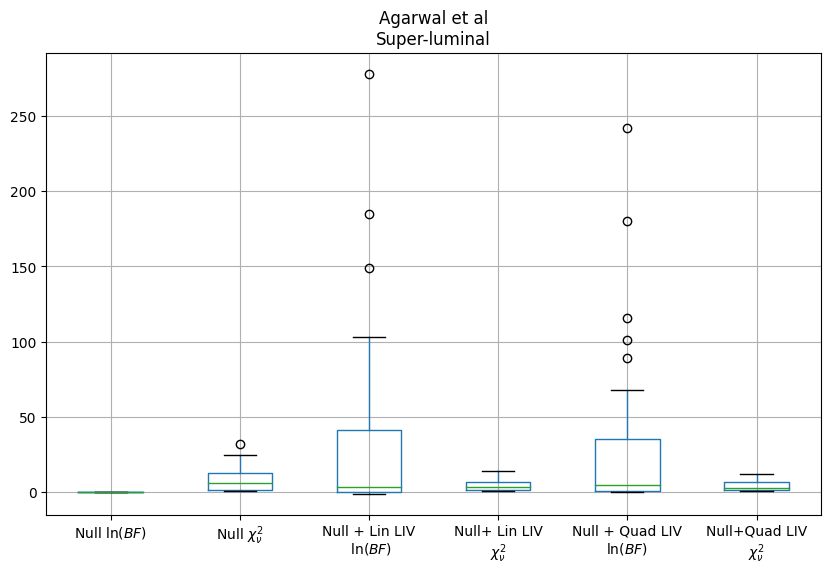

In [21]:
plt.figure(figsize=(10, 6))
temp= final.drop(['GRB', 'E0 (keV)', 'redshift'], inplace=False, axis=1)
temp.columns = ['Null $\ln(BF)$', 'Null $\chi^2_{\\nu}$', 'Null + Lin LIV\n $\ln(BF)$', 'Null+ Lin LIV\n$\chi^2_{\\nu}$', 'Null + Quad LIV\n$\ln(BF)$', 'Null+Quad LIV\n$\chi^2_{\\nu}$']

temp.boxplot()
# plt.yticks
plt.title('Agarwal et al\nSuper-luminal')
# plt.ylim(-20, 20)
plt.show()